# Application to image generation on MNIST

This notebook provides a practical implementation of the theoretical concepts explained in the notebook **theory.ipynb**, based on the original work of [Song, et al. (2021)](https://arxiv.org/abs/2011.13456).

In particular, we apply score-based generative modeling with SDEs to the MNIST dataset. We present two concrete examples of such diffusion processes, and illustrate how to train a time-dependent score network to learn the gradient of the data distribution at different noise levels.

The goal is to demonstrate how the abstract notions of forward and reverse SDEs, score matching, and Langevin/Euler sampling translate into an end-to-end generative pipeline on real image data.

## Imports, device, seed

In [1]:
# Libs externes
from utils.imports import *

# Libs internes
from models.score_net import ScoreNet
from models.loss import loss_VE, loss_VP
from models.sampling import euler_sampler_VE, euler_sampler_VP
from models.training import train_score_model
from utils.ts_gen import *
from utils.utils import *
from utils.ts_to_img import *

In [2]:
# CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Set the random seed for reproducibility
set_seed(0)

## MNIST Dataset and hyperparameters

We consider the well-studied MNIST dataset ([Y. LeCun](https://www.lri.fr/~marc/Master2/MNIST_doc.pdf)), in which the data’s intrinsic dimensionality is clearly less than $D$ (the number of pixels). The dataset consists of gray-valued digital images, each having $28×28$ pixels and showing one hand-written digit. The dataset provides a finite number of images that are divided into $60,000$ training and $10,000$ test images. While each image contains $n = 784$ pixels, the support of $X$ will likely lie in a subset of a much lower dimension. Also, since the images are grouped into ten diﬀerent classes, one can expect the support to be disjoint
with a substantial distance between the diﬀerent clusters.

In [4]:
# Hyperparameters
batch_size = 32
lr = 1e-4
n_epochs = 50
num_steps = 500

In [5]:
trainset_MNIST = MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader_MNIST = DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=True)
len(trainset_MNIST)

60000

In [6]:
testset_MNIST = MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader_MNIST = DataLoader(testset_MNIST, batch_size=batch_size, shuffle=True)
len(testset_MNIST)

10000

In [7]:
trainset_MNIST[0][0].shape

torch.Size([1, 28, 28])

## An example of Variance Exploding SDE

Let's consider the following SDE:

\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1], \quad \sigma > 0 \quad \text{fixed}
\end{align*}

Recall that $$\quad \mathbf{x}_t \in \mathbb{R}^D, \quad \mathbf{w}_t \in \mathbb{R}^D, \quad D = 784$$

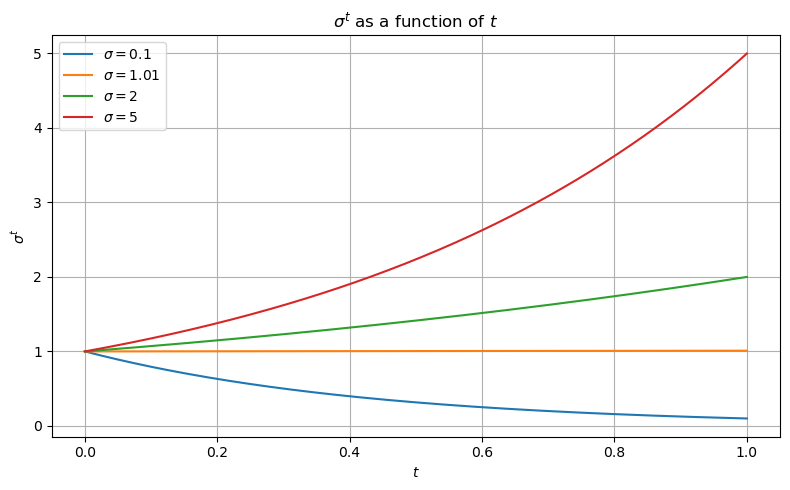

In [8]:
show_sigma_t_curves(sigmas=[0.1, 1.01, 2, 5], t_range=(0, 1))

The function $f(t) = \sigma^t$, defined for $t \in \mathbb{R}$, is continuous and strictly increasing when $\sigma > 1$.

If we sample this function at regularly spaced time intervals, i.e.,

$$
\sigma^{t_0}, \sigma^{t_1}, \sigma^{t_2}, \dots \quad \text{with } t_k = t_0 + k \cdot \Delta t,
$$

the resulting sequence forms a **geometric progression**, since:

$$
\frac{\sigma^{t_{k+1}}}{\sigma^{t_k}} = \frac{\sigma^{t_0 + (k+1)\Delta t}}{\sigma^{t_0 + k\Delta t}} = \sigma^{\Delta t},
$$

which is constant across all steps.

### Transition kernel

Since there is no drift term, the solution is given by integrating the noise term:

$$
\mathbf{x}_t = \mathbf{x}_0 + \int_0^t \sigma^s d\mathbf{w}_s
$$

The term $\int_0^t \sigma^s d\mathbf{w}_s$ is a **Wiener integral** since $f(s) = \sigma^s$ is deterministic. <br>Consequently, the EDS solution is a Gaussian random variable. All we need to do is find its mean and covariance, which characterize the distribution.

$$
\mathbb{E}[\mathbf{x}_t] = \mathbb{E}[\mathbf{x}_0] + 
\underbrace{\mathbb{E}\left[\int_0^t \sigma^s \, d\mathbf{w}(s)\right]}_{= 0}
= \mathbf{x}_0
$$

$$
\text{Var}[\mathbf{x}_t] = \text{Cov}\left[\int_0^t \sigma^s d\mathbf{w}_s\right] = \int_0^t \sigma^{2s} ds \cdot \mathbf{I_D} = \int_0^t e^{2s \log \sigma} ds \cdot \mathbf{I_D} = \left[\frac{1}{2 \log \sigma} e^{2s \log \sigma}\right]_0^t \cdot \mathbf{I_D} = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1) \cdot \mathbf{I_D}
$$

We now conclude that the **transition density** (or more generally, the **transition kernel** for distributions that don’t have a density):

$$
\boxed{
p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_t; \mathbf{x}_0, \frac{1}{2 \log \sigma}(\sigma^{2t} - 1) \mathbf{I_D}\right)
}
$$

We can then define the weighting function $\lambda(t)$ as:

$$
\boxed{\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)}
$$

which corresponds exactly to the variance term in the transition kernel.

### Prior distribution

Since $x_t = x_0 + \epsilon$ with $x_0\sim p_0$, $\epsilon \sim \mathcal{N}\left(\mathbf{0}, \lambda(t)\mathbf{I_D} \right)$ and $x_0 \perp\!\!\!\perp \epsilon$, the marginal distribution $p_t$ is given by:

$$
p_t(\mathbf{x}) = \int_{\mathbb{R}^D} p_0(\mathbf{y}) \cdot \mathcal{N}(\mathbf{x}; \mathbf{y}, \lambda(t)\mathbf{I_D}) , d\mathbf{y}.
$$

At $t = 1$, if $\sigma \gg 1$, the noise dominates the data distribution. The convolution can then be approximated by a Gaussian with mean $\mathbb{E}[\mathbf{x}_0]$ and covariance $\lambda(1)\mathbf{I_D}$:

$$
p_{t=1}(\mathbf{x}) \approx \mathcal{N}(\mathbb{E}[\mathbf{x}_0], \lambda(1)\mathbf{I_D}).
$$

If the data is centered, i.e. $\mathbb{E}[\mathbf{x}_0] = 0$, this reduces to:

$$
\boxed{
p_{t=1}(\mathbf{x}) \approx \mathcal{N}(0, \lambda(1)\mathbf{I_D})
}
$$

with:

$$
\boxed{
\lambda(1) = \frac{1}{2 \log \sigma}(\sigma^2 - 1)
}
$$

This distribution is independent of the data and can be sampled easily. It is used as the prior in the reverse-time SDE.

<div align="center">

<img src="figures/convolution.png" width="70%"/>

</div>

We have assumed that $p_0$ is centered. However, this assumption is **not always true in practice**, especially depending on how the data is preprocessed. For instance, MNIST have a non-zero mean:

In [9]:
# Compute the average pixel value across all images in the MNIST training set
mean_MNIST = sum(img.sum().item() for img, _ in trainset_MNIST) / sum(img.numel() for img, _ in trainset_MNIST)
mean_MNIST

0.13066047797803165

<div align="center">

<img src="figures/black_digits.png" width="20%"/>
<figcaption style="margin-top: 10px; font-size: 90%;">
If you set an outlier for x_mean in sampling, you'll see all-black images.
</figcaption>

</div>

### Exploding variance

Assuming $\mathbf{x}_0 \sim \mathcal{N}(0, \mathrm{var}_0 \cdot \mathbf{I_D})$, we have:

\begin{align*}
\text{Var}[\mathbf{x}_t]
&= \text{Var} \left[ \mathbf{x}_0 + \int_0^t \sigma^s \, d\mathbf{w}_s \right] \\[0.5em]
&= \text{Var}[\mathbf{x}_0] + \int_0^t \sigma^{2s} \, ds \cdot \mathbf{I_D} \\[0.5em]
&= \mathrm{var}_0 \cdot \mathbf{I_D} + \left[ \frac{1}{2 \log \sigma} \left( \sigma^{2t} - 1 \right) \right] \cdot \mathbf{I_D} \\[0.5em]
&= \left( \mathrm{var}_0 + \frac{ \sigma^{2t} - 1 }{2 \log \sigma} \right) \cdot \mathbf{I_D} \\[0.5em]
&=  (\mathrm{var}_0 + \lambda(t)) \cdot \mathbf{I_D}.
\end{align*}

For $\sigma > 1$, the variance increases exponentially with $t$ and **explodes** as $t \to 1$, dominating the initial variance.

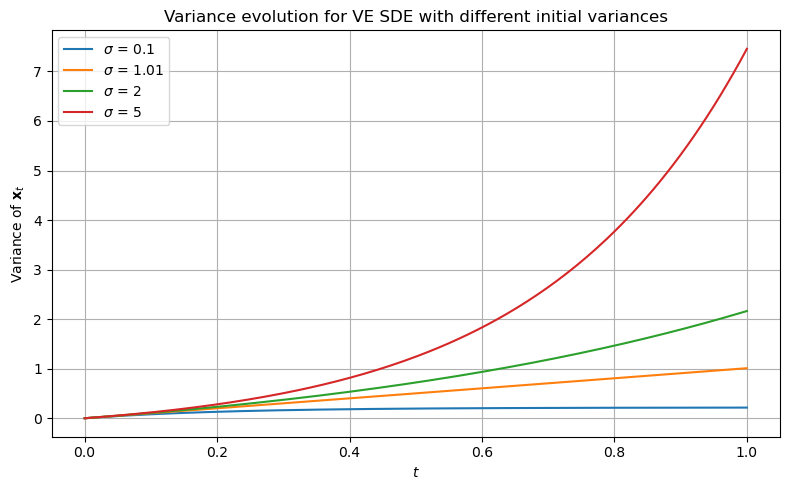

In [10]:
show_VE_variance_curves(sigmas=[0.1, 1.01, 2, 5], t_range=(0, 1))

To ensure that the noise injected at time t = 1 is sufficiently strong, we typically want:

$$
\boxed{
\text{std}[\mathbf{x}_1] \approx \text{maximum pairwise distance in the dataset}.}
$$

For the MNIST dataset, where images are normalized to the range [0, 1] and represented as vectors in $\mathbb{R}^{784}$, the maximum possible Euclidean distance between two images is:

$$
\left\|\mathbf{x}_1 - \mathbf{x}_2\right\|_2 \leq \sqrt{784} = 28.
$$

So the total noise injected up to time $t = 1$ has:

$$
\text{std}[\mathbf{x}_1] = \sqrt{\lambda(t)} = \sqrt{ \frac{\sigma^2 - 1}{2 \log \sigma} }.
$$

Solving this equation for $\text{std}[\mathbf{x}_1] = 28$ yields approximately:

$$
\sigma \approx 83.28.
$$

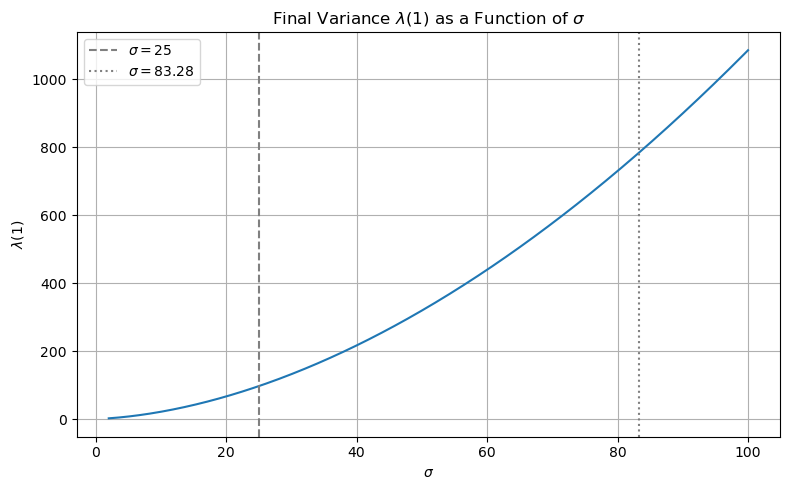

In [11]:
show_lambda1_VE_vs_sigma(sigmas_range=(2, 100))

The value $\boxed{\sigma=25}$ appears to be a good **trade-off**. For that value we find $\text{std}[\mathbf{x}_1] \approx 9.9$ and the final noise is sufficiently large, encouraging true generative learning while keeping training stable and efficient.

As we can see, $\lambda(1)$ grows quickly with $\sigma$:
- With $\sigma=25$, we get $\lambda(1) \approx 97 \Rightarrow \mathbf{x}_1 = \mathbf{x}_0 + \mathcal{N}(0, 97)$.
- With $\sigma=83.28$, we get $\lambda(1) \approx 784 \Rightarrow \mathbf{x}_1 = \mathbf{x}_0 + \mathcal{N}(0, 784)$.

In addition, the maximum distance between two images is actually on average much smaller than 28.

In [55]:
sigma = 25.0

### Main functions of the model

In [56]:
# Diffusion: g(t)
def diffusion_VE(t):
    t = t.to(device)
    return sigma ** t

# Std of the perturbation kernel p_{0t}(x(t) | x(0))
def perturbation_kernel_std_VE(t):
    t = t.to(device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / (2. * np.log(sigma)))

### Loss function

Since the the conditional distribution $p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0)$ is a Gaussian, we can compute the score analytically:

\begin{align*}
\nabla_{\mathbf{x}_t} \log p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0)
&= \nabla_{\mathbf{x}_t} \log \left[\frac{1}{\sqrt{(2\pi)^D |\lambda(t)\mathbf{I_D}|}} 
    \exp\left( -\frac{1}{2} (\mathbf{x}_t - \mathbf{x}_0)^\top \left( \lambda(t)\mathbf{I_D} \right)^{-1}(\mathbf{x}_t - \mathbf{x}_0) \right) \right] \\
&= \nabla_{\mathbf{x}_t} \log \left[\frac{1}{\sqrt{(2\pi \lambda(t))^D}} \exp\left( -\frac{1}{2\lambda(t)} \|\mathbf{x}_t - \mathbf{x}_0\|^2 \right) \right] \\
&= \nabla_{\mathbf{x}_t} \left[-\frac{D}{2} \log(2\pi \lambda(t)) - \frac{1}{2\lambda(t)} \|\mathbf{x}_t - \mathbf{x}_0\|^2 \right]\\
&= -\frac{1}{\lambda(t)} \left(\mathbf{x}_t - \mathbf{x}_0\right)
\end{align*}

Recall that because the conditional distribution is Gaussian: $p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_0, \lambda(t) \mathbf{I_D})$, sampling from this distribution is equivalent to: 
$\mathbf{x}_t = \mathbf{x}_0 + \sqrt{\lambda(t)} \, \mathbf{z}, \quad \text{where } \mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I_D}).$

Thus the loss is given by:

\begin{align*}
\mathcal{L}(\theta) 
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{x}_t \sim p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0)} \left[ \left\| s_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{x}_t \sim p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0)} \left[ \left\| s_\theta(\mathbf{x}_t, t) + \frac{1}{\lambda(t)} (\mathbf{x}_t - \mathbf{x}_0) \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I_D})} \left[ \left\| s_\theta(\mathbf{x}_0 + \sqrt{\lambda(t)} \, \mathbf{z}, t) + \frac{1}{\sqrt{\lambda(t)}} \mathbf{z} \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I_D})} \left[ \left\| \sqrt{\lambda(t)} \, s_\theta(\mathbf{x}_0 + \sqrt{\lambda(t)} \mathbf{z}, t) + \mathbf{z} \right\|^2 \right] \right]
\end{align*}

In conclusion:

$$
\boxed{\mathcal{L}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I_D})} \left[ \left\| \sqrt{\lambda(t)} \, s_\theta(\mathbf{x}_0 + \sqrt{\lambda(t)} \mathbf{z}, t) + \mathbf{z} \right\|^2 \right] \right]}
$$

### Training with Early Stopping

In [14]:
# Model and optimizer initialization for the VE process
score_model_MNIST_VE = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VE)
score_model_MNIST_VE = torch.nn.DataParallel(score_model_MNIST_VE).to(device)
optimizer_MNIST_VE = Adam(score_model_MNIST_VE.parameters(), lr=lr)

In [15]:
ckpt_path_MNIST_VE = 'checkpoints/ckpt_best_MNIST_VE.pth'

In [16]:
train_losses_MNIST_VE, val_losses_MNIST_VE = train_score_model(
    model=score_model_MNIST_VE,
    train_loader=train_loader_MNIST,
    test_loader=test_loader_MNIST,
    loss_fn=loss_VE,
    optimizer=optimizer_MNIST_VE,
    perturbation_kernel_std=perturbation_kernel_std_VE,
    device=device,
    ckpt_path=ckpt_path_MNIST_VE,
    n_epochs=50,
    patience=5
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1: Train Loss = 315.8610, Val Loss = 92.1482


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2: Train Loss = 66.0437, Val Loss = 51.1374


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3: Train Loss = 43.6849, Val Loss = 38.3338


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4: Train Loss = 35.2348, Val Loss = 33.1822


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5: Train Loss = 30.4935, Val Loss = 28.6365


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6: Train Loss = 27.1037, Val Loss = 26.5164


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7: Train Loss = 25.1533, Val Loss = 24.6076


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8: Train Loss = 23.6197, Val Loss = 22.6836


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9: Train Loss = 22.6561, Val Loss = 21.4563


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10: Train Loss = 21.9013, Val Loss = 21.2350


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11: Train Loss = 21.4061, Val Loss = 21.0901


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12: Train Loss = 20.9683, Val Loss = 20.7784


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13: Train Loss = 20.8169, Val Loss = 20.3397


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14: Train Loss = 20.4347, Val Loss = 19.7800


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15: Train Loss = 20.0931, Val Loss = 19.8839


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16: Train Loss = 19.8391, Val Loss = 19.7019


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17: Train Loss = 19.6328, Val Loss = 19.3356


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18: Train Loss = 19.4621, Val Loss = 18.5600


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19: Train Loss = 18.9028, Val Loss = 19.2078


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20: Train Loss = 19.0957, Val Loss = 18.6721


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21: Train Loss = 18.9539, Val Loss = 18.5654


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22: Train Loss = 18.6991, Val Loss = 18.8430


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23: Train Loss = 18.5560, Val Loss = 18.3556


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24: Train Loss = 18.2834, Val Loss = 18.5709


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25: Train Loss = 18.4893, Val Loss = 18.0518


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26: Train Loss = 18.4461, Val Loss = 18.2147


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27: Train Loss = 18.3522, Val Loss = 17.7482


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28: Train Loss = 18.1856, Val Loss = 17.5252


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29: Train Loss = 18.1009, Val Loss = 17.7313


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30: Train Loss = 18.0634, Val Loss = 17.6052


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 31: Train Loss = 17.9520, Val Loss = 17.8029


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 32: Train Loss = 17.8523, Val Loss = 17.8788


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 33: Train Loss = 17.8649, Val Loss = 18.3786
Early stopping at epoch 33


In [17]:
score_model_MNIST_VE.training

False

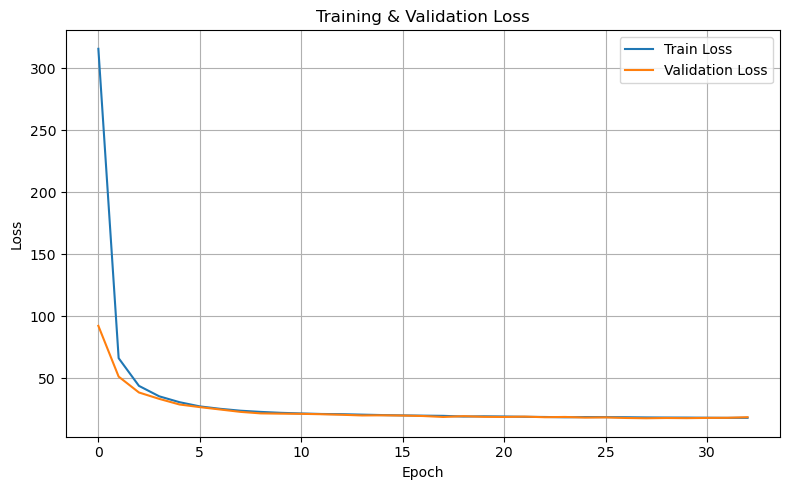

In [18]:
show_loss_curves(train_losses_MNIST_VE, val_losses_MNIST_VE)

The training loss (blue) and validation loss (orange) drop rapidly during the first ~10 epochs, which is typical of a good initial learning phase. From around epoch 10 onward, both curves stabilize around a value close to 20. They remain close to each other with very little gap, and **there is no visible sign of overfitting** — the validation loss does not increase again.

This indicates that the model is learning the target distribution effectively without overfitting the training dataset. The fact that validation loss stays nearly equal to training loss is a strong sign of good generalization. Finally, the stable plateau in both curves suggests that the model has likely reached a local or global minimum in the loss landscape.

### Sampling

Recall that the reverse-time SDE is given by

$$
dx = \left[ f(x, t) - g(t)^2 \nabla_x \log p_t(x) \right] dt + g(t) \, d\bar{\mathbf{w}}.
$$

Since we have chosen the forward SDE to be

$$
dx = \sigma^t \, d\mathbf{w}, \quad t \in [0, 1]
$$

The reverse-time SDE is given by

$$
\boxed{dx = -\sigma^{2t} \nabla_x \log p_t(x) \, dt + \sigma^t \, d\bar{\mathbf{w}}.}
$$

To sample from our time-dependent score-based model $s_\theta(x, t)$, we first draw a sample from the prior distribution

$$
p_1 \approx \mathcal{N} \left(x; \, 0, \, \frac{1}{2 \log(\sigma)} (\sigma^2 - 1) \mathbf{I} \right),
$$

and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by

$$
dx = -\sigma^{2t} s_\theta(x, t) \, dt + \sigma^t \, d\bar{\mathbf{w}}.
$$

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler–Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization of the SDE, replacing $dt$ with $\Delta t$ and $d\bar{\mathbf{w}}$ with $\Delta\bar{\mathbf{w}}$. When applied to our reverse-time SDE, we obtain the following iteration rule:

$$
\boxed{x_{t - \Delta t} = x_t + \sigma^{2t} s_\theta(x_t, t) \, \Delta t + \sigma^t \sqrt{\Delta t} \, \mathbf{z}_t}
$$

where $\mathbf{z}_t \sim \mathcal{N}(0, \mathbf{I})$.

In [69]:
# Loading weights
score_model_MNIST_VE_sample = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VE)
score_model_MNIST_VE_sample = torch.nn.DataParallel(score_model_MNIST_VE_sample).to(device)
score_model_MNIST_VE_sample.load_state_dict(torch.load("checkpoints/ckpt_best_MNIST_VE.pth", map_location=device))

<All keys matched successfully>

In [70]:
samples_MNIST_VE = euler_sampler_VE(
    score_model=score_model_MNIST_VE_sample,
    perturbation_kernel_std=perturbation_kernel_std_VE,
    diffusion_coeff=diffusion_VE,
    batch_size=16,
    num_steps=800,
    device=device
)

  0%|          | 0/800 [00:00<?, ?it/s]

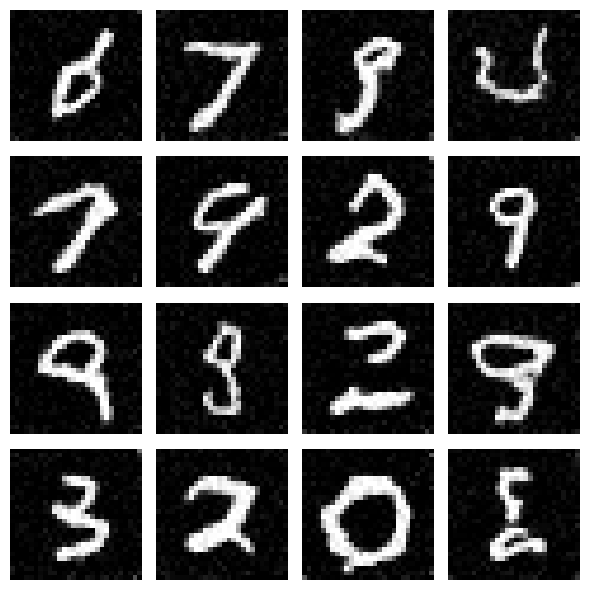

In [71]:
show_image_grid(samples_MNIST_VE)

## An example of Variance Preserving SDE : Ornstein-Uhlenbeck process

Let's consider the following [Ornstein-Uhlenbeck](https://fr.wikipedia.org/wiki/Processus_d%27Ornstein-Uhlenbeck) process with $\theta = 1$, $\mu = 0$ and $\sigma = \sqrt{2}$:

$$
d\mathbf{x}_t = -\mathbf{x}_t \, dt + \sqrt{2} \, d\mathbf{w}_t
$$

### Transition kernel

We can solve this SDE using the variation of parameters method.

First, add $\mathbf{x}_t \, dt$ to both sides:

$$
d\mathbf{x}_t + \mathbf{x}_t \, dt = \sqrt{2} \, d\mathbf{w}_t
$$

Now multiply both sides by $e^t$:

$$
e^t \, d\mathbf{x}_t + e^t \mathbf{x}_t \, dt = e^t \sqrt{2} \, d\mathbf{w}_t
$$

Therefore, the equation becomes:

$$
d\left( e^t \mathbf{x}_t \right) = e^t \sqrt{2} \, d\mathbf{w}_t
$$

Integrating from $0$ to $t$:

$$
e^t \mathbf{x}_t - \mathbf{x}_0 = \int_0^t e^s \sqrt{2} \, d\mathbf{w}_s
$$

Thus:

$$
\mathbf{x}_t = e^{-t} \mathbf{x}_0 + \sqrt{2} e^{-t} \int_0^t e^s \, d\mathbf{w}_s
$$

The term $\int_0^t e^s \, d\mathbf{w}_s$ is a Wiener integral with mean zero and covariance:

$$
\text{Cov} = \int_0^t e^{2s} \, ds \cdot I = \frac{e^{2t} - 1}{2} \cdot I_D
$$

This leads to:

$$
p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) = e^{-t} \mathbf{x}_0 + \sqrt{2} e^{-t} \cdot \mathcal{N}\left(0, \frac{e^{2t} - 1}{2} I_D \right)
$$

Simplifying:

$$
\boxed{p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; e^{-t} \mathbf{x}_0, (1 - e^{-2t}) I_D)
}
$$

We can then define the weighting function $\lambda(t)$ as:

$$
\boxed{\lambda(t) = (1 - e^{-2t})}
$$

### Prior distribution

Thus, the marginal distribution at time $t$ is the convolution:

$$
p_t(\mathbf{x}) = (p_0 * \mathcal{N}(0, \lambda(t)\mathbf{I}))(\mathbf{x}),
$$

with:

$$
\lambda(t) = 1 - e^{-2t}.
$$

If $t$ is large enough, we have:

$$
\lambda(1) \approx 1.
$$

Therefore, the **marginal distribution** becomes approximately:

$$
\boxed{
p_{t=1}(\mathbf{x}) \approx \mathcal{N}(0, \mathbf{I}).}
$$

This standard Gaussian is used as the **prior** distribution for sampling.

### Preserving variance

Assuming $\mathbf{x}_0 \sim \mathcal{N}(0,  \mathrm{var}_0 \cdot \mathbf{I})$

\begin{align*}
\text{Var}[\mathbf{x}_t]
&= e^{-2t} \cdot \text{Var}[\mathbf{x}_0] + 2 \int_0^t e^{-2(t - s)} ds \cdot \mathbf{I} \\[0.5em]
&= e^{-2t} \cdot \mathrm{var}_0 \cdot \mathbf{I} + 2 \cdot \frac{1 - e^{-2t}}{2} \cdot \mathbf{I} \\[0.5em]
&= e^{-2t} \cdot \mathrm{var}_0 \cdot \mathbf{I} + (1 - e^{-2t}) \cdot \mathbf{I} \\[0.5em]
&= \left( e^{-2t} \cdot \mathrm{var}_0 + (1 - e^{-2t}) \right) \cdot \mathbf{I}.
\end{align*}

The variance is **preserved**, converging to $\mathbf{I}$ as $t \to \infty$, regardless of the initial variance.

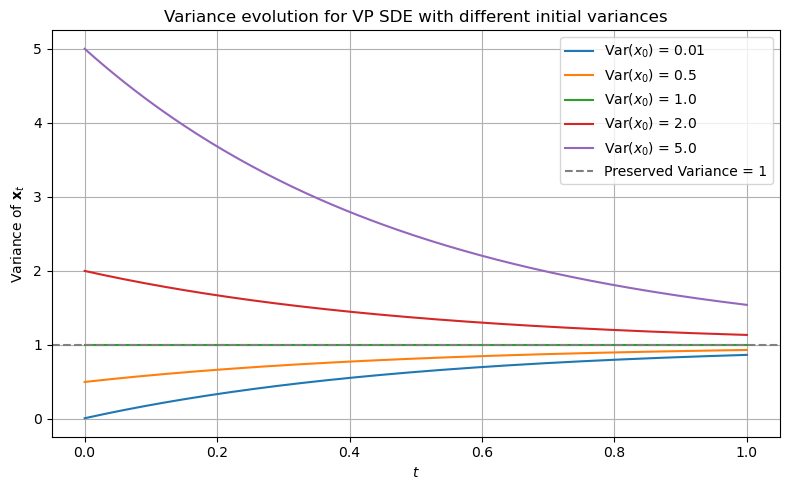

In [22]:
show_VP_variance_curves(var0_list=[0.01, 0.5, 1.0, 2.0, 5.0])

### Main functions of the model

In [23]:
sigma = np.sqrt(2.0)

# Drift : f(x, t)
def drift_VP(x, t):
    return -x

# Diffusion : g(t)
def diffusion_VP(t):
    return torch.full_like(t, sigma)

# Std of the perturbation kernel p_{0t}(x(t) | x(0))
def perturbation_kernel_std_VP(t):
    return torch.sqrt(1. - torch.exp(-2. * t)).to(device)

### Loss function

Since the conditional distribution $p_t(\mathbf{x}_t \mid \mathbf{x}_0)$ is Gaussian, we can compute the score analytically:

\begin{align*}
\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t \mid \mathbf{x}_0)
&= \nabla_{\mathbf{x}_t} \log \left[
\frac{1}{\sqrt{(2\pi)^{D} |(1 - e^{-2t}) \mathbf{I}|}} 
\exp\left(
- \frac{1}{2} (\mathbf{x}_t - e^{-t} \mathbf{x}_0)^\top \left( (1 - e^{-2t}) \mathbf{I} \right)^{-1} (\mathbf{x}_t - e^{-t} \mathbf{x}_0)
\right)
\right] \\
&= \nabla_{\mathbf{x}_t} \log \left[
\frac{1}{\sqrt{(2\pi (1 - e^{-2t}))^D}} 
\exp\left(
- \frac{1}{2(1 - e^{-2t})} \| \mathbf{x}_t - e^{-t} \mathbf{x}_0 \|^2
\right)
\right] \\
&= \nabla_{\mathbf{x}_t} \left[
- \frac{D}{2} \log(2\pi (1 - e^{-2t})) - \frac{1}{2(1 - e^{-2t})} \| \mathbf{x}_t - e^{-t} \mathbf{x}_0 \|^2
\right] \\
&= - \frac{1}{1 - e^{-2t}} \left( \mathbf{x}_t - e^{-t} \mathbf{x}_0 \right)
\end{align*}

Let 
$$
\mathbf{z} = \frac{\mathbf{x}_t - e^{-t} \mathbf{x}_0}{\sqrt{1 - e^{-2t}}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

Then:

$$
\mathbf{x}_t = e^{-t} \mathbf{x}_0 + \sqrt{1 - e^{-2t}} \, \mathbf{z}
$$

This allows us to rewrite the score matching loss for the Ornstein-Uhlenbeck process as:

\begin{align*}
\mathcal{L}(\theta) 
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{x}_t \sim p_t(\mathbf{x}_t \mid \mathbf{x}_0)} \left[ \left\| s_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t \mid \mathbf{x}_0) \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \left\| s_\theta(\mathbf{x}_t, t) + \frac{1}{\lambda(t)} (\mathbf{x}_t - e^{-t} \mathbf{x}_0) \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \lambda(t) \, \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \left\| s_\theta(e^{-t} \mathbf{x}_0 + \sqrt{1 - e^{-2t}} \, \mathbf{z}, t) + \frac{1}{\sqrt{1 - e^{-2t}}} \mathbf{z} \right\|^2 \right] \right] \\
&= \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \left\| \sqrt{1 - e^{-2t}} \, s_\theta(e^{-t} \mathbf{x}_0 + \sqrt{1 - e^{-2t}} \, \mathbf{z}, t) + \mathbf{z} \right\|^2 \right] \right]
\end{align*}

In conclusion:

$$
\boxed{\mathcal{L}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \left[ \mathbb{E}_{\mathbf{x}_0 \sim p_0(\mathbf{x})} \, \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \left\| \sqrt{\lambda(t)} \, s_\theta(e^{-t} \mathbf{x}_0 + \sqrt{\lambda(t)} \, \mathbf{z}, t) + \mathbf{z} \right\|^2 \right] \right]}
$$

In [24]:
# Model and optimizer initialization for the OU process (VP)
score_model_MNIST_VP = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VP)
score_model_MNIST_VP = torch.nn.DataParallel(score_model_MNIST_VP).to(device)
optimizer_MNIST_VP = Adam(score_model_MNIST_VP.parameters(), lr=lr)
score_model_MNIST_VP.training

True

In [25]:
ckpt_path_MNIST_VP = 'checkpoints/ckpt_best_MNIST_VP.pth'

In [26]:
train_losses_MNIST_VP, val_losses_MNIST_VP = train_score_model(
    model=score_model_MNIST_VP,
    train_loader=train_loader_MNIST,
    test_loader=test_loader_MNIST,
    loss_fn=loss_VP,
    optimizer=optimizer_MNIST_VP,
    perturbation_kernel_std=perturbation_kernel_std_VP,
    device=device,
    ckpt_path=ckpt_path_MNIST_VP,
    n_epochs=50,
    patience=5
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1: Train Loss = 237.0766, Val Loss = 64.4289


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2: Train Loss = 51.8666, Val Loss = 43.5237


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3: Train Loss = 39.3939, Val Loss = 35.2624


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4: Train Loss = 33.6591, Val Loss = 31.0270


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5: Train Loss = 30.6144, Val Loss = 28.8989


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6: Train Loss = 28.3790, Val Loss = 27.4503


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7: Train Loss = 26.9060, Val Loss = 26.0909


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8: Train Loss = 25.9314, Val Loss = 25.3311


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9: Train Loss = 25.0142, Val Loss = 24.3398


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10: Train Loss = 24.2042, Val Loss = 24.2788


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11: Train Loss = 23.6238, Val Loss = 23.2116


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12: Train Loss = 23.2797, Val Loss = 22.4974


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13: Train Loss = 22.7824, Val Loss = 22.8355


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14: Train Loss = 22.7297, Val Loss = 22.5933


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15: Train Loss = 22.1473, Val Loss = 22.2234


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16: Train Loss = 22.2072, Val Loss = 21.8534


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17: Train Loss = 21.9140, Val Loss = 22.0581


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18: Train Loss = 21.6742, Val Loss = 21.7220


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19: Train Loss = 21.5179, Val Loss = 21.1950


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20: Train Loss = 21.3533, Val Loss = 21.2537


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21: Train Loss = 21.3451, Val Loss = 21.1237


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22: Train Loss = 21.1737, Val Loss = 21.0946


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23: Train Loss = 20.8550, Val Loss = 20.8657


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24: Train Loss = 20.9344, Val Loss = 20.4096


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25: Train Loss = 20.6243, Val Loss = 20.4599


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26: Train Loss = 20.5533, Val Loss = 20.5987


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27: Train Loss = 20.5639, Val Loss = 20.5683


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28: Train Loss = 20.4550, Val Loss = 20.2200


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29: Train Loss = 20.2581, Val Loss = 20.1478


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30: Train Loss = 20.2694, Val Loss = 20.1945


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 31: Train Loss = 20.1630, Val Loss = 19.7625


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 32: Train Loss = 20.3188, Val Loss = 21.1285


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 33: Train Loss = 20.0124, Val Loss = 19.8480


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 34: Train Loss = 20.1999, Val Loss = 19.8497


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 35: Train Loss = 19.7253, Val Loss = 19.6724


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 36: Train Loss = 19.9961, Val Loss = 19.5375


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 37: Train Loss = 19.7477, Val Loss = 19.2712


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 38: Train Loss = 19.7561, Val Loss = 19.7655


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 39: Train Loss = 19.6721, Val Loss = 19.9427


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 40: Train Loss = 19.6263, Val Loss = 19.5892


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 41: Train Loss = 19.5755, Val Loss = 19.5615


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 42: Train Loss = 19.5574, Val Loss = 19.2747
Early stopping at epoch 42


In [27]:
score_model_MNIST_VP.training

False

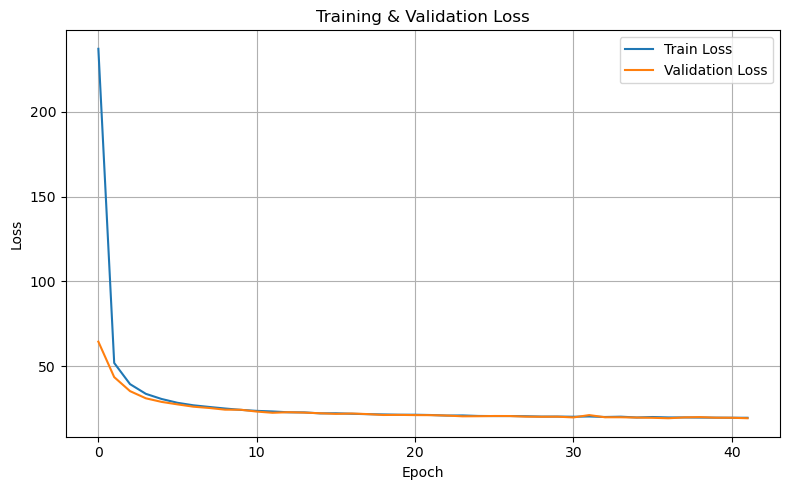

In [28]:
show_loss_curves(train_losses_MNIST_VP, val_losses_MNIST_VP)

### Sampling

Recall that the reverse-time SDE is given by

$$
dx = \left[ f(x, t) - g(t)^2 \nabla_x \log p_t(x) \right] dt + g(t) \, d\bar{\mathbf{w}}.
$$

Since we have chosen the forward SDE to be

$$
d\mathbf{x}_t = -\mathbf{x}_t \, dt + \sqrt{2} \, d\mathbf{w}_t
$$

The reverse-time SDE is given by

$$
\boxed{d\mathbf{x} = -\left[ \mathbf{x}_t + 2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) \right] dt + \sqrt{2} \, d\bar{\mathbf{w}}_t}
$$

To sample from our trained time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1$, which is approximately:

$$
p_1(\mathbf{x}) = \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

We then solve the reverse-time SDE using numerical methods. Using our estimated score function, the SDE becomes:

$$
d\mathbf{x} = -\left[ \mathbf{x}_t + 2 s_\theta(\mathbf{x}_t, t) \right] dt + \sqrt{2} \, d\bar{\mathbf{w}}_t
$$

We discretize this SDE using the [Euler–Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method), replacing $dt$ by a small step $\Delta t$ and $d\bar{\mathbf{w}}$ by $\sqrt{\Delta t} \cdot \mathbf{z}_t$ with $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

This yields the update rule:

$$
\boxed{\mathbf{x}_{t - \Delta t} = \mathbf{x}_t + \left( \mathbf{x}_t + 2 \cdot s_\theta(\mathbf{x}_t, t) \right) \Delta t + \sqrt{2 \Delta t} \cdot \mathbf{z}_t}
$$

where $\mathbf{z}_t \sim \mathcal{N}(0, \mathbf{I})$.

In [52]:
score_model_MNIST_VP_sample = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VP)
score_model_MNIST_VP_sample = torch.nn.DataParallel(score_model_MNIST_VP_sample).to(device)
score_model_MNIST_VP_sample.load_state_dict(torch.load("checkpoints/ckpt_best_MNIST_VP.pth", map_location=device))

<All keys matched successfully>

In [53]:
samples_MNIST_VP = euler_sampler_VP(
    score_model=score_model_MNIST_VP_sample,
    diffusion_coeff=diffusion_VP,
    batch_size=16,
    num_steps=800,
    device=device
)

  0%|          | 0/800 [00:00<?, ?it/s]

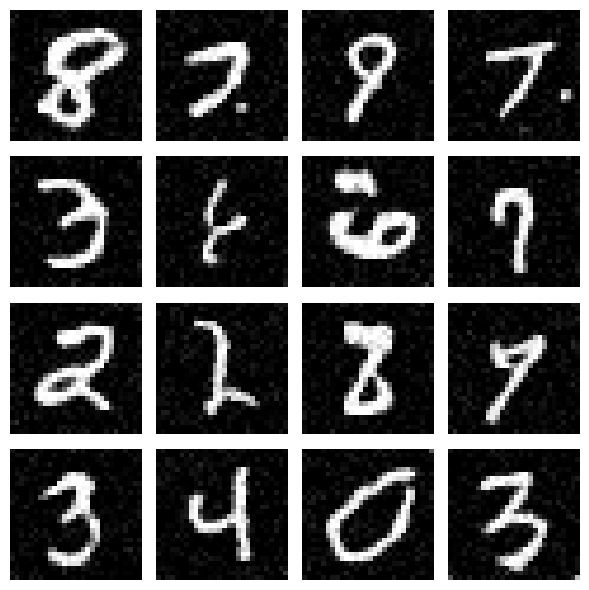

In [54]:
show_image_grid(samples_MNIST_VP)

## General Scheme for VE and VP SDEs

More generally, VE SDEs are defined as follows:

### Variance Exploding (VE) framework

The Variance Exploding (VE) process consists in the following forward diffusion process:

$$
\boxed{
d\mathbf{x} = \sqrt{\frac{d[\sigma^2_t]}{dt}} \, d\mathbf{w}.
}
$$

Its associated transition kernel is:

$$
p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_t; \mathbf{x}_0, [\sigma^2_t - \sigma^2_0] \, \mathbf{I_D}\right) \approx \mathcal{N}(\mathbf{x}_0, \sigma^2_t\, \mathbf{I_D}).
$$

Given a large enough $\sigma^2_{t=1}$, $\mathbf{x}_{t=1}$ is approximately distributed as 
$$
x_{t=1} \sim \mathcal{N}(0, \sigma^2_{t=1}\, \mathbf{I_D}).
$$

### Variance Preserving (VP) framework

The Variance Preserving (VP) process consists in the following forward diffusion process:

$$
\boxed{d\mathbf{x} = -\frac{1}{2} \beta(t) \mathbf{x} \, dt + \sqrt{ \beta(t) } \, d\mathbf{w}.}
$$

Its associated transition kernel is:

$$
p_{0t}(\mathbf{x}_t \mid \mathbf{x}_0) \sim \mathcal{N} \left(
\mathbf{x}_0 \cdot e^{ -\frac{1}{2} \int_0^t \beta(s) ds },
\left(1 - e^{ -\int_0^t \beta(s) ds } \right) \mathbf{I_D}
\right).
$$

For large enough $\int_0^1 \beta(s) ds$, the marginal distribution of $\mathbf{x}_{t=1}$ is approximately:

$$
\mathbf{x}_{t=1} \sim \mathcal{N}(0, \mathbf{I_D}),
$$

and thus becomes independent of $\mathbf{x}_0$.